# ASHRAE Data - EDA

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import plotly as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from math import sqrt

import pandas_profiling as ppf
import sweetviz as sv
import missingno as msno

import matplotlib
from matplotlib import pyplot as plt

import pprint
import datetime
from math import sqrt

import pickle

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.arima import ndiffs

print("pmdarima version: %s" % pm.__version__)

#import tools as tl

import os
import glob

pd.options.display.float_format = '{:.2f}'.format
pd.set_option("precision", 2)

pmdarima version: 1.8.2


# Building Information

In [2]:
###Distribution of building sizes
# Find Most Significant buildings in squarefootage
path = './/data_clean//bldg.pkl'
vis_outpath = './/visualization//'
df_bldg = pd.read_pickle(path)
df_bldg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 869 to 44
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype        
---  ------       --------------  -----        
 0   site_id      1449 non-null   uint8        
 1   building_id  1449 non-null   uint16       
 2   primary_use  1449 non-null   category     
 3   square_feet  1449 non-null   int32        
 4   year_built   675 non-null    period[A-DEC]
 5   floor_count  1449 non-null   int32        
dtypes: category(1), int32(2), period[A-DEC](1), uint16(1), uint8(1)
memory usage: 39.7 KB


In [3]:
df_bldg.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
869,8,869,Entertainment/public assembly,875000,NaT,1
1148,13,1148,Office,861524,NaT,-1
375,3,375,Office,850354,1989,-1
365,3,365,Healthcare,819577,1922,-1
269,2,269,Entertainment/public assembly,809530,1958,-1


In [4]:
df_bldg.groupby(by=['site_id'])['building_id'].count()

site_id
0     105
1      51
2     135
3     274
4      91
5      89
6      44
7      15
8      70
9     124
10     30
11      5
12     36
13    154
14    102
15    124
Name: building_id, dtype: int64

In [5]:
df_bldg['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

### Add Building Size Feature

In [6]:
# Build building size features
cut_labels = ['S','M','L', 'XL', 'XXL']
cut_bins = [0,50000,100000,250000,450000,900000]

# Process Square Footage
# Enable Hue of building size
df_bldg['bldg_size'] = pd.cut(df_bldg['square_feet'], bins=cut_bins, labels=cut_labels)
df_bldg.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count,bldg_size
869,8,869,Entertainment/public assembly,875000,NaT,1,XXL
1148,13,1148,Office,861524,NaT,-1,XXL
375,3,375,Office,850354,1989,-1,XXL
365,3,365,Healthcare,819577,1922,-1,XXL
269,2,269,Entertainment/public assembly,809530,1958,-1,XXL


## View Building Sizes and Size

Text(0.5, 1.0, 'Site IDs and Building Sizes')

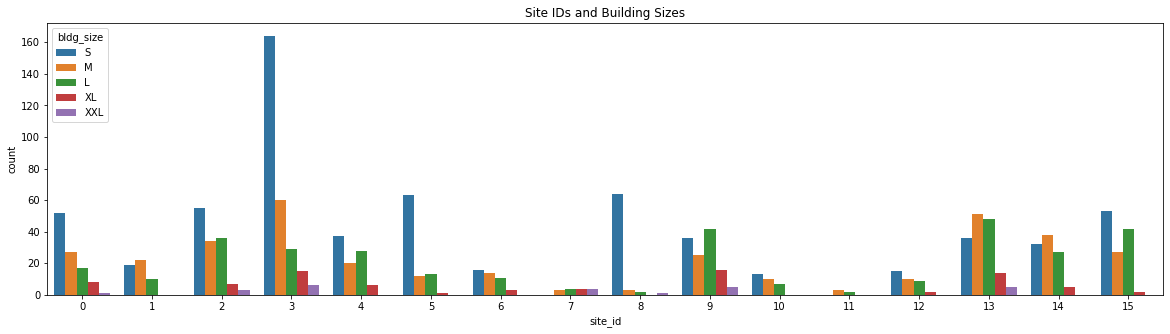

In [7]:
sns.color_palette('inferno_r')
plt.rcParams['figure.figsize']=20,5
g = sns.countplot(x='site_id',
        data=df_bldg,
        hue='bldg_size')
g.set_title('Site IDs and Building Sizes')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Education'),
  Text(1, 0, 'Entertainment/public assembly'),
  Text(2, 0, 'Food sales and service'),
  Text(3, 0, 'Healthcare'),
  Text(4, 0, 'Lodging/residential'),
  Text(5, 0, 'Manufacturing/industrial'),
  Text(6, 0, 'Office'),
  Text(7, 0, 'Other'),
  Text(8, 0, 'Parking'),
  Text(9, 0, 'Public services'),
  Text(10, 0, 'Religious worship'),
  Text(11, 0, 'Retail'),
  Text(12, 0, 'Services'),
  Text(13, 0, 'Technology/science'),
  Text(14, 0, 'Utility'),
  Text(15, 0, 'Warehouse/storage')])

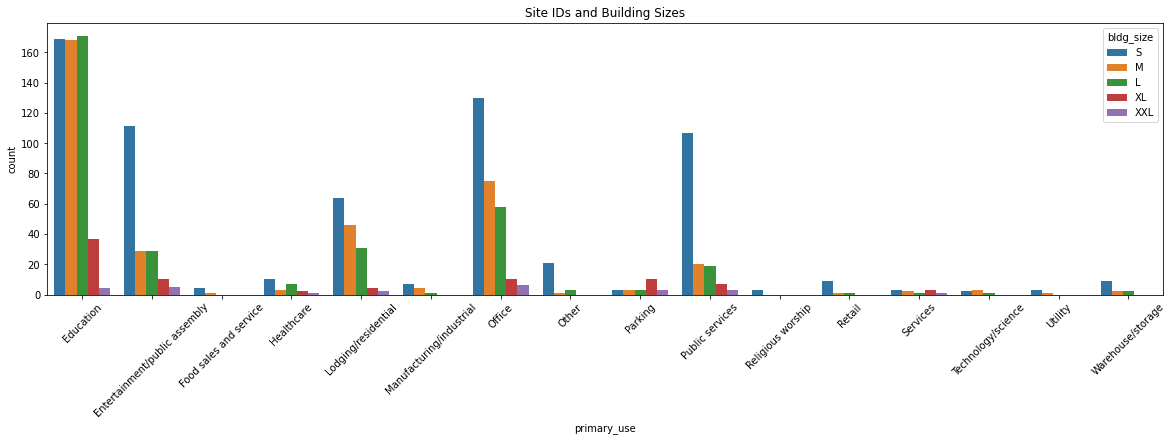

In [8]:
sns.color_palette('inferno_r')
plt.rcParams['figure.figsize']=20,5
g = sns.countplot(x='primary_use',
        data=df_bldg,
        hue='bldg_size')
g.set_title('Site IDs and Building Sizes')
plt.xticks(rotation=45)

# Build Summary Dataframe of Building + meter Files
#### Add features

Build a summary dataset showing key statistics
Interested in correlations between seasons, weekends, weekdays

In [9]:
# Count how much data is missing per building
import warnings
warnings.filterwarnings('ignore')

data_path = '.\\data_clean\\buildings_by_meter\\' + '*.pkl'
files = glob.glob(data_path)

bldg_dict = {}
bldgs = []
meters = []
train_obs = []
fnames = []

len_zero = []
len_nan = []
per_data = []

cats = []

corr_meter_to_airtemp = []
corr_meter_to_airtemp_wknd = []
corr_meter_to_airtemp_wkdy = []

corr_meter_to_winter = []
corr_meter_to_spring = []
corr_meter_to_summer = []
corr_meter_to_fall = []

meters = []
sq_ft = []
s_id = []
flr_ct = []
b_size = []
w_day = []
season = []

m_name = []

# Iterate over each file in the buildings for each meter
for f in files:

    fnames.append(os.path.basename(f))
    
    # Read single bldg_meter file
    df = pd.read_pickle(f)
    
    # Get that training data
    df_sample = df.loc['2016-1-1':'2016-12-31'] # Get training data
    
    # Get the Building Name
    bldg = df_sample.iloc[0]['building_id']  
    bldgs.append(bldg)

    # Get the Meter Name
    meter = df_sample.iloc[0]['meter']
    meters.append(meter)
    
    if meter == 0:
        met = 'Elec'
    elif meter == 1:
        met = 'CWater'
    elif meter == 2:
        met = 'Steam'
    elif meter == 3:
        met = 'HWater'
    
    m_name.append(met)
    
    # Get the squft
    sq_ft.append(df_bldg[df_bldg['building_id'] == bldg].iloc[0]['square_feet'])
    
    # Get building size
    b_size.append(df_bldg[df_bldg['building_id'] == bldg].iloc[0]['bldg_size'])
  
    # Put Site Id
    s_id.append(df_bldg[df_bldg['building_id'] == bldg].iloc[0]['site_id'])
    
    # Get the flr ct
    flr_ct.append(df_bldg[df_bldg['building_id'] == bldg].iloc[0]['floor_count'])
    
    # Find out total observations
    train_ob = len(df_sample['meter_reading'])
    train_obs.append(train_ob)
    
    # Get the building primary use
    cats.append(df_bldg[df_bldg['building_id'] == bldg].iloc[0]['primary_use'])
    
    # Find how many zeros are in data
    len_zero.append((df_sample['meter_reading'] == 0).sum())
    
    # Percent of data that is not zero
    per_data.append(100-((df_sample['meter_reading'] == 0).sum()/len(df_sample['meter_reading'])*100))
    
# #     print(df_sample['meter_reading'].notnull().count()/len(df_sample['meter_reading']))

    # Correlation of air temperature to meter reading
    corr = df_sample['meter_reading'].corr(df_sample['air_temperature'])
    corr_meter_to_airtemp.append(corr)
    
    # Correlation of air temperature to weekend
    samp = df_sample[df_sample['weekend'] == 1]
    corr = samp['meter_reading'].corr(samp['air_temperature'])
    corr_meter_to_airtemp_wknd.append(corr)
    
    # Correlation of air temperature to weekday
    samp = df_sample[df_sample['weekend'] == 0]
    corr = samp['meter_reading'].corr(samp['air_temperature'])
    corr_meter_to_airtemp_wkdy.append(corr)
    
    # Correlation of air temperature to winter
    samp = df_sample[df_sample['season'] == 1]
    corr = samp['meter_reading'].corr(samp['air_temperature'])
    corr_meter_to_winter.append(corr)
    
    # Correlation of air temperature to spring
    samp = df_sample[df_sample['season'] == 2]
    corr = samp['meter_reading'].corr(samp['air_temperature'])
    corr_meter_to_spring.append(corr)
    
    # Correlation of air temperature to summer
    samp = df_sample[df_sample['season'] == 3]
    corr = samp['meter_reading'].corr(samp['air_temperature'])
    corr_meter_to_summer.append(corr)
    
    # Correlation of air temperature to fall
    samp = df_sample[df_sample['season'] == 4]
    corr = samp['meter_reading'].corr(samp['air_temperature'])
    corr_meter_to_fall.append(corr)
    
    
    
#     bldgs.append(bld)

bldg_dict['file_name'] = fnames
bldg_dict['building'] = bldgs
bldg_dict['meter'] = meters
bldg_dict['len_train'] = train_obs
bldg_dict['len_zero'] = len_zero
bldg_dict['per_data'] = per_data
bldg_dict['category'] = cats
bldg_dict['corr_meter_to_airtemp'] = corr_meter_to_airtemp
bldg_dict['corr_meter_to_airtemp_wknd'] = corr_meter_to_airtemp_wknd
bldg_dict['corr_meter_to_airtemp_wkdy'] = corr_meter_to_airtemp_wkdy

bldg_dict['corr_meter_to_airtemp_winter'] = corr_meter_to_winter
bldg_dict['corr_meter_to_airtemp_spring'] = corr_meter_to_spring
bldg_dict['corr_meter_to_airtemp_summer'] = corr_meter_to_summer
bldg_dict['corr_meter_to_airtemp_fall'] = corr_meter_to_fall

bldg_dict['square_feet'] = sq_ft
bldg_dict['site_id'] = s_id
bldg_dict['floor_count'] = flr_ct
bldg_dict['bldg_size'] = b_size
bldg_dict['meter_name'] = m_name

df_bldg_stats = pd.DataFrame(bldg_dict).sort_values(by=['per_data','building'],ascending=False)
df_bldg_stats.reset_index(inplace=True,drop=True)
df_bldg_stats.to_csv('.\\data_clean\\building_reading_stats.csv',index=False)

In [10]:
## Building Size to Air Temperature Correlation

In [11]:
df_bldg_stats

,file_name,building,meter,len_train,len_zero,per_data,category,corr_meter_to_airtemp,corr_meter_to_airtemp_wknd,corr_meter_to_airtemp_wkdy,corr_meter_to_airtemp_winter,corr_meter_to_airtemp_spring,corr_meter_to_airtemp_summer,corr_meter_to_airtemp_fall,square_feet,site_id,floor_count,bldg_size,meter_name
0,1448_0.pkl,1448,0,7452,0,100.00,Office,-0.28,-0.20,-0.32,-0.22,-0.29,-0.14,-0.27,92271,15,-1,M,Elec
1,1447_0.pkl,1447,0,7471,0,100.00,Lodging/residential,0.04,0.00,0.05,0.25,0.03,0.15,0.35,29775,15,-1,S,Elec
2,1445_0.pkl,1445,0,7449,0,100.00,Education,-0.33,-0.29,-0.35,-0.16,-0.33,0.33,-0.18,4298,15,-1,S,Elec
3,1443_0.pkl,1443,0,7472,0,100.00,Education,-0.06,-0.05,-0.06,-0.05,-0.14,0.08,0.11,40311,15,-1,S,Elec
4,1442_0.pkl,1442,0,7472,0,100.00,Public services,0.05,0.18,0.05,-0.14,-0.04,-0.10,0.13,99541,15,-1,M,Elec
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2370,1250_2.pkl,1250,2,8784,8536,2.82,Education,-0.16,-0.16,-0.16,0.12,NaN,NaN,NaN,232139,14,-1,L,Steam
2371,279_3.pkl,279,3,8783,8732,0.58,Education,0.00,-0.00,0.01,NaN,0.05,NaN,NaN,49384,2,-1,S,HWater
2372,287_3.pkl,287,3,8783,8740,0.49,Office,0.09,0.04,0.10,NaN,NaN,0.03,0.08,33713,2,-1,S,HWater
2373,1022_1.pkl,1022,1,8774,8766,0.09,Education,-0.01,-0.01,-0.01,0.03,-0.02,NaN,NaN,84346,10,2,M,CWater


## Meter to Air Temp

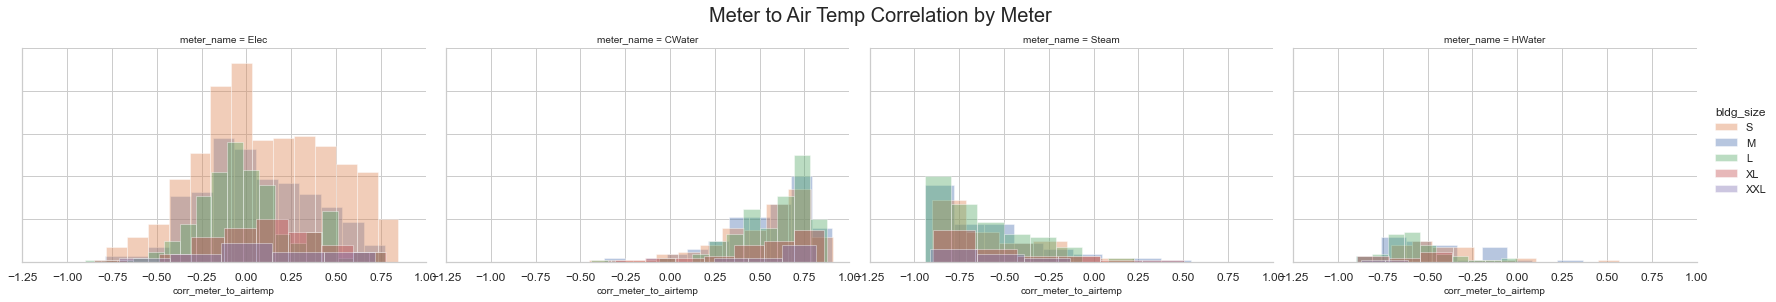

In [12]:
sns.set(style="whitegrid")
g = sns.FacetGrid(df_bldg_stats, col='meter_name', height = 4, aspect = 1.5, hue='bldg_size')
g.map(sns.distplot, "corr_meter_to_airtemp", kde = False, hist = True, rug = False)
g.set_titles(size = 10)
g.set_xlabels(size = 10)
g.set_yticklabels(fontsize = 25)
g.set_xticklabels(fontsize = 12)
g.fig.suptitle('Meter to Air Temp Correlation by Meter', fontsize=20, x = 0.5, y = 1.05)
g.add_legend(label_order=cut_labels)
#plb.savefig('Distribution_easy.png',dpi=50,bbox_inches='tight')



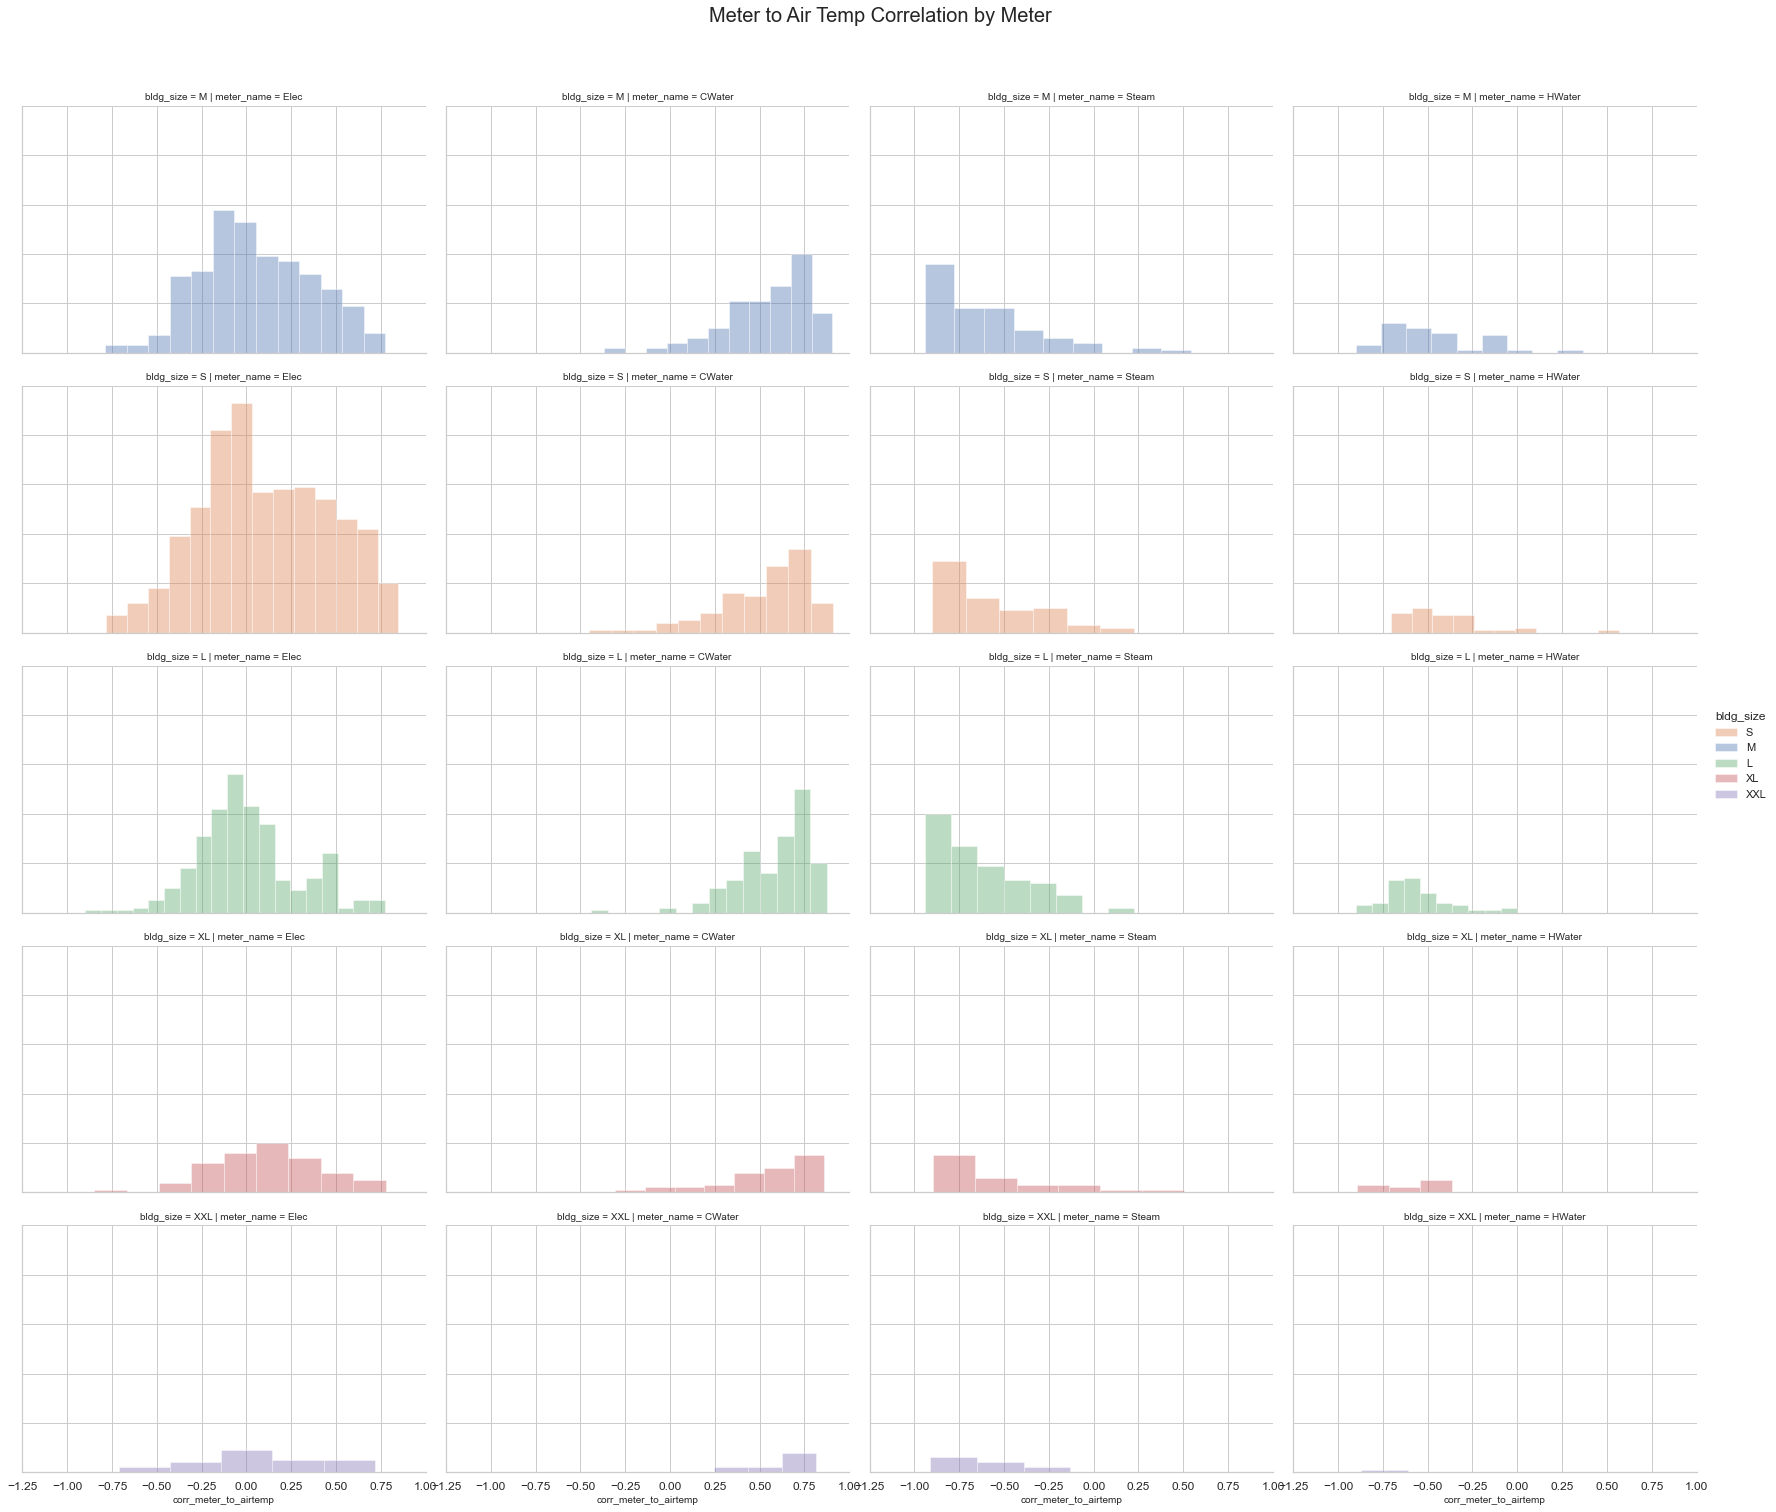

In [13]:
sns.set(style="whitegrid")
g = sns.FacetGrid(df_bldg_stats, col='meter_name', row='bldg_size',height = 4, aspect = 1.5, hue='bldg_size')
g.map(sns.distplot, "corr_meter_to_airtemp", kde = False, hist = True, rug = False)
g.set_titles(size = 10)
g.set_xlabels(size = 10)
g.set_yticklabels(fontsize = 25)
g.set_xticklabels(fontsize = 12)
g.fig.suptitle('Meter to Air Temp Correlation by Meter', fontsize=20, x = 0.5, y = 1.05)
g.add_legend(label_order=cut_labels)
#plb.savefig('Distribution_easy.png',dpi=50,bbox_inches='tight')

## Meter Count

Text(0.5, 1.0, 'Meter Count')

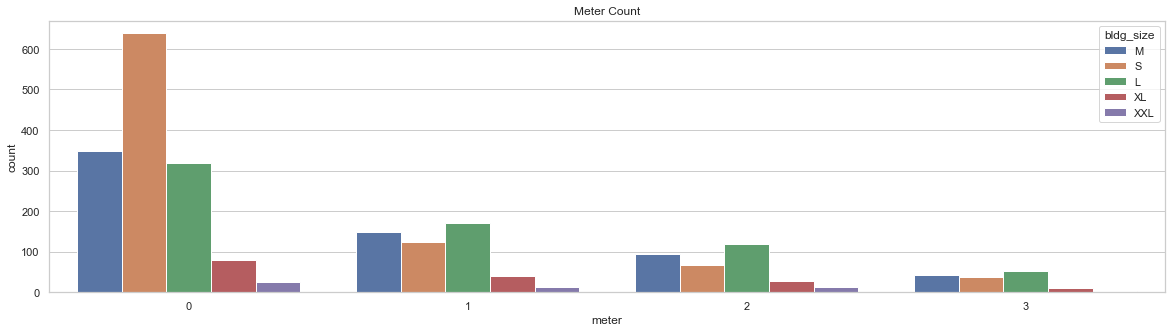

In [14]:
sns.color_palette('inferno_r')
plt.rcParams['figure.figsize']=20,5
g = sns.countplot(x='meter',data=df_bldg_stats,hue='bldg_size')
g.set_title('Meter Count')

In [27]:
df_wtrain = pd.read_pickle('.\\data_clean\\wtrain.pkl')
df_wtrain.head(3)

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 00:00:00,0,25.00,6.00,20.00,NaN,1019.70,0.00,0.00
2016-01-01 01:00:00,0,24.40,NaN,21.10,-1.00,1020.20,70.00,1.50
2016-01-01 02:00:00,0,22.80,2.00,21.10,0.00,1020.20,0.00,0.00


In [121]:
df_sample = df_wtrain[['site_id','air_temperature']]
df_sample = df_sample.pivot(columns='site_id').reset_index()
df_sample.index = df_sample['timestamp']
df_sample.drop('timestamp',axis=1,inplace=True)
df_sample

air_temperature                                           \
site_id                          0    1     2     3     4    5     6      7    
timestamp                                                                      
2016-01-01 00:00:00           25.00 3.80 15.60 10.00   NaN  NaN   NaN  -1.80   
2016-01-01 01:00:00           24.40 3.70 13.90  9.40  9.40 5.00 10.00  -1.70   
2016-01-01 02:00:00           22.80 2.60 13.30  8.90  8.30 3.00 10.00  -2.70   
2016-01-01 03:00:00           21.10 2.00 12.20  7.80  7.80 4.00  9.40  -2.30   
2016-01-01 04:00:00           20.00 2.30 11.70  7.80  5.00 4.00  7.80  -2.60   
...                             ...  ...   ...   ...   ...  ...   ...    ...   
2016-12-31 19:00:00           22.80 8.10 15.00  9.40 12.80 9.00  8.90 -10.30   
2016-12-31 20:00:00           23.30 7.20 16.10  8.90 11.10 8.00  8.90  -9.90   
2016-12-31 21:00:00           23.30 6.90 16.70  8.90 11.10 8.00  8.90  -9.90   
2016-12-31 22:00:00           22.80 6.90 16.70  8.90 11.70 8.00  7.80  -9.80   
2016-12-31 23:00:00           20.60 7.50 16.70  8.90 12.80 8.00  7.20  -9.60   

                                                                     
site_id                8     9      10     11   12    13   14    15  
timestamp                                                            
2016-01-01 00:00:00 25.00   NaN    NaN  -1.80 1.90 -8.30  NaN   NaN  
2016-01-01 01:00:00 24.40 10.00 -10.60  -1.70 1.60 -8.30 5.60 -1.00  
2016-01-01 02:00:00 22.80 10.00 -11.10  -2.70 0.70 -7.80 5.60 -1.00  
2016-01-01 03:00:00 21.10 10.00 -10.00  -2.30 0.80 -7.80 5.60 -1.00  
2016-01-01 04:00:00 20.00 10.00 -13.30  -2.60 2.90 -7.20 5.00   NaN  
...                   ...   ...    ...    ...  ...   ...  ...   ...  
2016-12-31 19:00:00 22.80 21.70  -4.40 -10.30 9.70 -3.30 6.70  3.00  
2016-12-31 20:00:00 23.30 21.70  -4.40  -9.90 9.70 -3.90 5.60  2.80  
2016-12-31 21:00:00 23.30 23.90  -4.40  -9.90 8.60 -4.40 5.60  2.80  
2016-12-31 22:00:00 22.80 25.00  -4.40  -9.80 8.20 -5.00 5.60  2.20  
2016-12-31 23:00:00 20.60 24.40  -5.00  -9.60 6.50 -5.60 6.10  1.70  

[8784 rows x 16 columns]

## View Air Temperature Data by Site

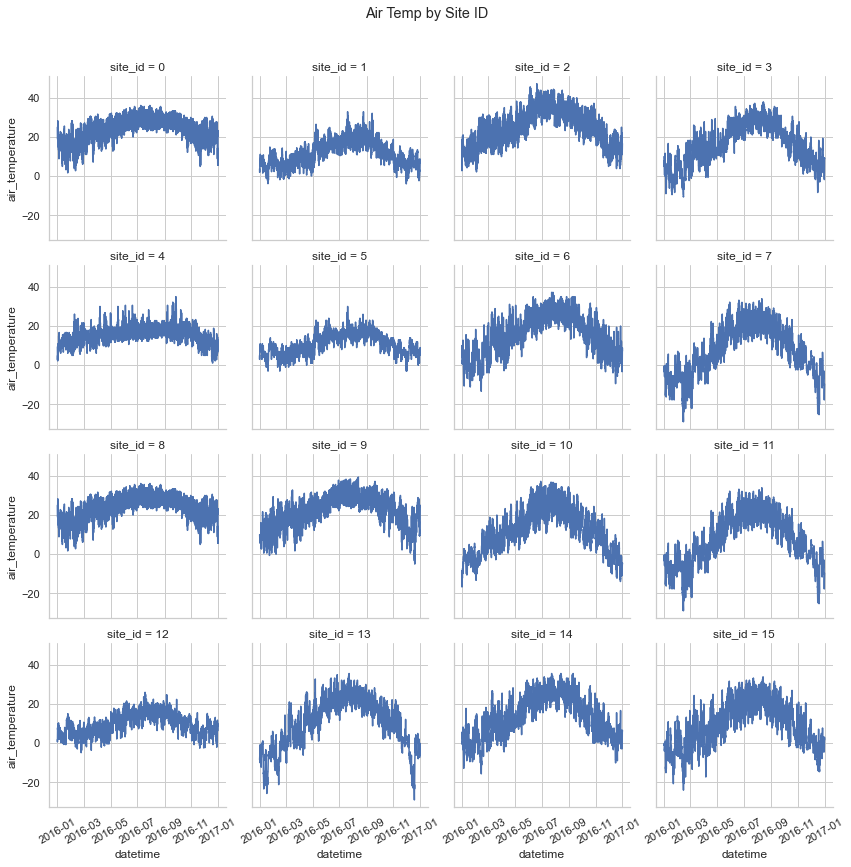

In [28]:
#TODO Put in aggregation here
df_wtrain["datetime"] = df_wtrain.index

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df_wtrain, col="site_id", palette="tab20c",col_wrap=4, height=3)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, 'datetime','air_temperature')

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=0.01)
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('Air Temp by Site ID')
grid.set_xticklabels(rotation=30)

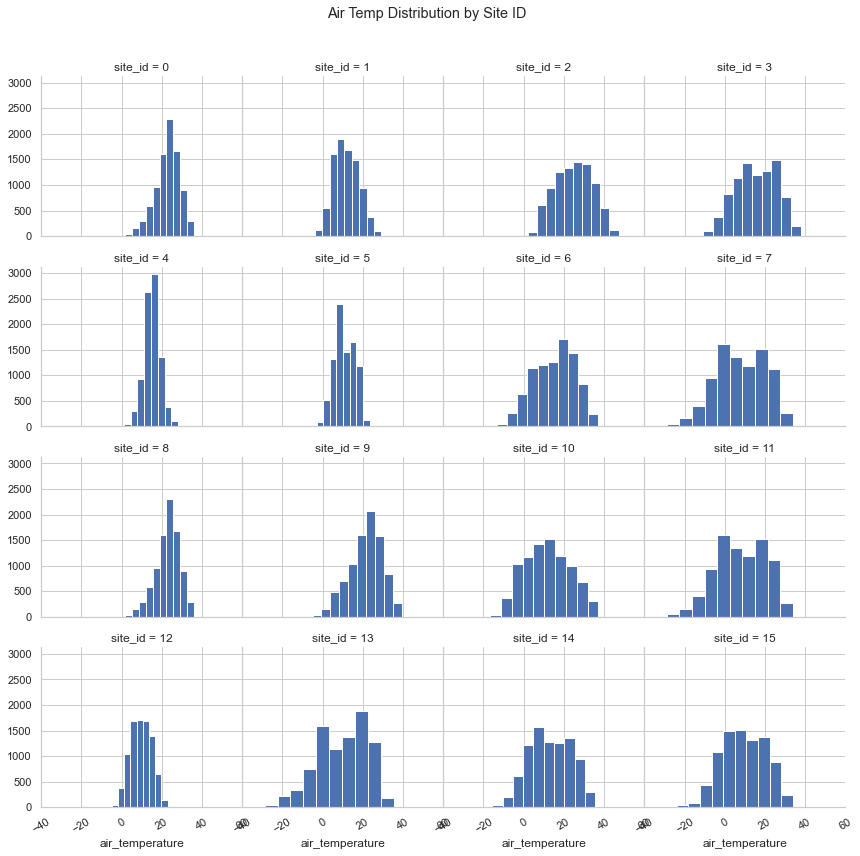

In [17]:
df_wtrain["datetime"] = df_wtrain.index

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df_wtrain, col="site_id", palette="tab20c",col_wrap=4, height=3)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.hist,'air_temperature')

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=0.01)
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('Air Temp Distribution by Site ID')
grid.set_xticklabels(rotation=30)

## Site ID and Sea Level Pressure

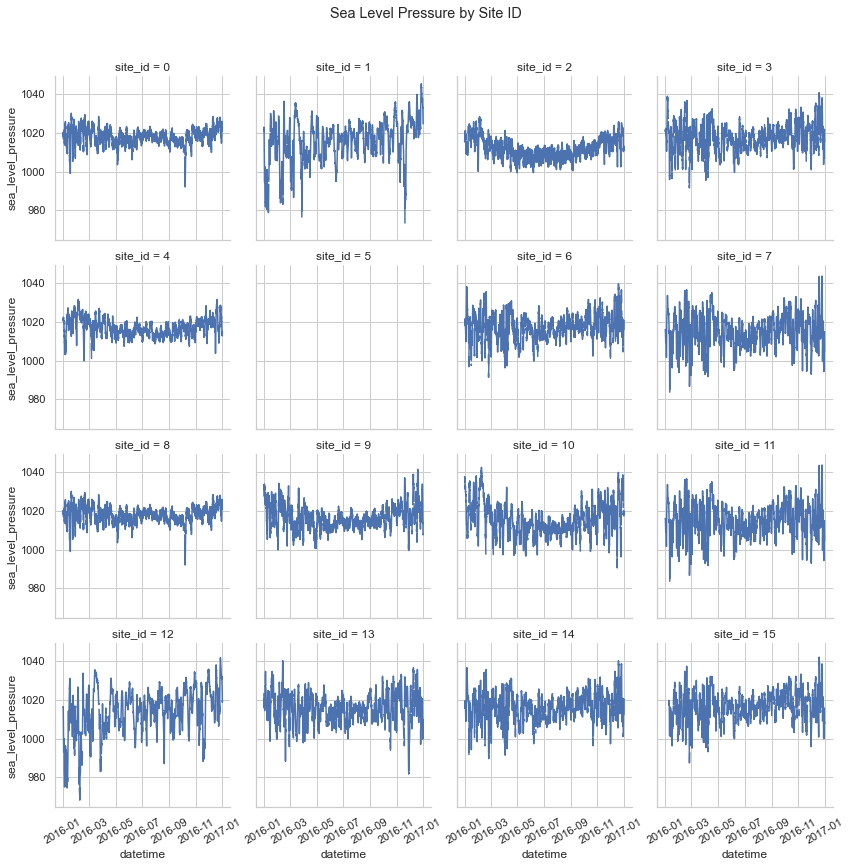

In [18]:
df_wtrain["datetime"] = df_wtrain.index

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df_wtrain, col="site_id", palette="tab20c",col_wrap=4, height=3)

# Draw a line plot to show the trajectory of each random walk
grid.map(plt.plot, 'datetime','sea_level_pressure')

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=0.01)
grid.fig.subplots_adjust(top=0.9)
grid.fig.suptitle('Sea Level Pressure by Site ID')
grid.set_xticklabels(rotation=30)

# Building size to correlations

In [19]:
df = pd.read_pickle('.\\data_clean\\buildings\\100.pkl')
df

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,row_id,month,season,day_of_week,dayname,weekend
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,100,0,0.00,0,Lodging/residential,24456,1968,-1,25.00,6.00,...,NaN,1019.70,0.00,0.00,NaN,1,1,4,Friday,0
2016-01-01 01:00:00,100,0,0.00,0,Lodging/residential,24456,1968,-1,24.40,NaN,...,-1.00,1020.20,70.00,1.50,NaN,1,1,4,Friday,0
2016-01-01 02:00:00,100,0,0.00,0,Lodging/residential,24456,1968,-1,22.80,2.00,...,0.00,1020.20,0.00,0.00,NaN,1,1,4,Friday,0
2016-01-01 03:00:00,100,0,0.00,0,Lodging/residential,24456,1968,-1,21.10,2.00,...,0.00,1020.10,0.00,0.00,NaN,1,1,4,Friday,0
2016-01-01 04:00:00,100,0,0.00,0,Lodging/residential,24456,1968,-1,20.00,2.00,...,-1.00,1020.00,250.00,2.60,NaN,1,1,4,Friday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,100,0,NaN,0,Lodging/residential,24456,1968,-1,27.80,4.00,...,0.00,1019.30,170.00,5.70,2259550.00,12,1,0,Monday,0
2018-12-31 20:00:00,100,0,NaN,0,Lodging/residential,24456,1968,-1,27.20,4.00,...,0.00,1019.40,170.00,5.70,2259679.00,12,1,0,Monday,0
2018-12-31 21:00:00,100,0,NaN,0,Lodging/residential,24456,1968,-1,27.80,NaN,...,0.00,1019.60,170.00,4.60,2259808.00,12,1,0,Monday,0


## Build Summary DataFrame of Single Building

In [25]:
len(b_size)

1449

In [26]:
len(m_name)

2375

In [17]:
len(files)

1449

In [18]:
len(bldgs)

1449

In [20]:
len(meters)

1449

In [21]:
len(cats)

1449

In [22]:
len(sq_ft)

1449

In [23]:
len(s_id)

1449

In [24]:
len(flr_ct)

1449

In [28]:
bldg_dict['file_name'] = files
bldg_dict['building'] = bldgs
bldg_dict['category'] = cats
bldg_dict['square_feet'] = sq_ft
bldg_dict['site_id'] = s_id
bldg_dict['floor_count'] = flr_ct
bldg_dict['bldg_size'] = b_size

# df_bldg_stats = pd.DataFrame(bldg_dict).sort_values(by=['building'],ascending=False)

# df_bldg_stats['meter'] = df_bldg_stats['meter'].astype(object)
# df_bldg_stats['meter'] = pd.Series(data=meters,name='meters')

# df_bldg_stats.reset_index(inplace=True,drop=True)
# df_bldg_stats.to_csv('.\\data_clean\\building_stats.csv',index=False)

for

ValueError: arrays must all be same length

## Feature Correlations

In [ ]:
data_path = '.\\data_clean\\buildings_by_meter\\' 
out_path = '.\\visualization\\correlations\\' 


bld_mtr = ['1073_2',
           '1073_1',
           '1073_0',
           '1073_1',
           '1073_2',
           '1220_2',
           '1220_1',
           '1220_0',
           '1372_1',
           '1156_2',
           '1156_1',
           '1156_0',
           '1148_0',
           '1148_1',
           '1148_2',
           '797_0',
           '797_1',
           '797_2',
           '1380_0',
           '1380_1',
           '1168_2',
           '1168_1',
           '1168_0',
           '1203_2',
           '1109_2',
           '1030_0',
           '1030_1',
           '1030_3',
           '1031_3',
           '1258_0',
           '1258_1',
           '1258_2',
           '1258_3',
           '1259_0',
           '1259_1',
           '1259_2',
           '1259_3']

for file in df_bldg_stats['file_name']:
    
    if file.split('.')[0] not in bld_mtr:
        continue
        
    app_path = data_path + str(file)
    df = pd.read_pickle(app_path)
    print(file)
    
    
#     plt.figure(figsize=(16, 6))
#     heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
#     heatmap.set_title(file.split('.')[0], fontdict={'fontsize':18}, pad=12);
#     # save heatmap as .png file
#     # dpi - sets the resolution of the saved image in dots/inches
#     # bbox_inches - when set to 'tight' - does not allow the labels to be cropped
#     plt.savefig(out_path + file.split('.')[0] + '.png', dpi=300, bbox_inches='tight',title=file.split('.')[0])
    plt.ioff()
    plt.figure(figsize=(16, 6))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title(file.split('.')[0], fontdict={'fontsize':18}, pad=16);
    plt.savefig(out_path + file.split('.')[0] + '.jpg', dpi=300, bbox_inches='tight',title=file.split('.')[0])

# Write Missing Data Visualization (Raw Data)

In [ ]:
source_folder = './/data_clean//buildings_by_meter//*.pkl'

missingno_folder = './/visualization//missingno//raw//'
feature_dist_folder = './/visualization//featuredist//'

files = glob.glob(source_folder)

for file in files:
    df = pd.read_pickle(file)
    bldg = df.iloc[0]['building_id']
    mtr = df.iloc[0]['meter']
    
    # 
    
#     fig_copy = fig.get_figure()
#     fig_copy.savefig(missingno_folder + str(bldg) + '_' + str(mtr) + '.png', bbox_inches = 'tight')
# bldgs = list(set(df_bldg_stats['building'].values))
# meters = df_bldg_stats['meter'].unique()

# for bld in bldgs:
#     if bld % 50 == 0:
#         print(bld)
#     df = pd.read_pickle('.//data_clean//buildings_by_meter//' + '1148_0.pkl')
    
    
# fig = msno.matrix(df)
# fig_copy = fig.get_figure()
# fig_copy.savefig('plot.png', bbox_inches = 'tight')

In [ ]:
df_bldg_stats['file_name']

In [ ]:
for bldg in df_bldg_stats['']

In [ ]:
# Write 
df = pd.read_pickle(file)

In [ ]:

# plt.style.use("dark_background")

In [ ]:
# Correlation of Meter Type to Airtemperature
sns.set(context='notebook', style='dark', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc={'figure.figsize':(40,20)})
sns.swarmplot(data=df_bldg_stats,x='meter_name',y='corr_meter_to_airtemp',hue='bldg_size', 
              hue_order=['XXL', 'XL', 'L', 'M', 'S']).set_title('Meter type Correlations to Air Temperature')

In [ ]:
# Correlation of Meter Type to Weekend
sns.set(context='notebook', style='dark', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc={'figure.figsize':(40,20)})
sns.swarmplot(data=df_bldg_stats,x='meter_name',y='corr_meter_to_airtemp_wknd',
              hue='category',
              ).set_title('Meter type Correlations to Weekend')

In [ ]:
# Correlation of Meter Type to Weekday
sns.set(context='notebook', style='dark', palette='deep', font='sans-serif', font_scale=2, color_codes=False, rc={'figure.figsize':(40,20)})
sns.swarmplot(data=df_bldg_stats,x='meter_name',y='corr_meter_to_airtemp_wkdy',
              hue='category',
              ).set_title('Meter type Correlations to Weekday')

In [ ]:
# Correlation of Season to Air Temperature in Winter
sns.swarmplot(data=df_bldg_stats,x='meter',y='corr_meter_to_airtemp_winter',hue='bldg_size').set_title('Meter type Correlations to Winter AirTemp')

## Distribution of Building Sizes

In [ ]:
fig = px.histogram(df_bldg, x="square_feet",nbins=50,title='Building Size Distribution')
fig.write_image(vis_outpath + 'Building Size Distribution'  + '.jpg')
fig.write_html(vis_outpath + 'Building Size Distribution' + '.html')

In [ ]:
sns.displot(df_bldg['square_feet'],kde=True,height=8.27, aspect=11.7/8.27)

### Top 5, Middle 5, Bottom 5 Buildings
Find sets of the buildings

In [ ]:
df_building_meta_top5 = df_bldg.head(5)
df_building_meta_bot5 = df_bldg.tail(5)
df_building_meta_mid5 = df_bldg.iloc[(df_bldg.shape[0] // 2) - 3:(df_bldg.shape[0]) // 2 + 2,:]

In [ ]:
df_building_meta_top5

In [ ]:
df_building_meta_bot5

In [ ]:
df_building_meta_mid5

In [ ]:
#Lists of building candidates
bld_large = list(df_building_meta_top5['building_id'].values)
bld_med = list(df_building_meta_mid5['building_id'].values)
bld_small = list(df_building_meta_bot5['building_id'].values)

In [ ]:
# List of Buidlings to process
bld_large

In [ ]:
bld_med

In [ ]:
bld_small

# READING DATA

Notes
- 1297 has all 4 meters
- 1259 has all 4 meters
- 1241 has all 4 meters
- 1258 has all 4 meters
- 1148 has 3 meters

In [ ]:
# Load meter
# 1258 has all meters

b_id = 1259 # Has all three meters
path = './/data_clean//buildings//' + str(b_id) + '.pkl'

df = pd.read_pickle(path)
df.shape

In [ ]:
df.info()

In [ ]:
# Missing Data
msno.matrix(df)

## Display meter readings with weather data

# Visualization of percentage missing data in train and test
# Outlier data table by building and meter
# % of good train
# % of good test

# Distribution of all buildings

## Load Building Data example

# Resample and Write Pickle

# Load Resamp

## Building Metadata - Histogram

# Process Single Building
## Pull single building

In [ ]:
# Settings
resamp = '1D' # 
width = ""

dropna_subset = ['meter_reading','air_temperature']

# Map of how we aggregate new data when it is resampled
agg_dict={'meter_reading':'sum', 
          'air_temperature':'max',
          'dew_temperature':'max',
          'cloud_coverage':'mean',
          'dew_temperature':'max',
          'precip_depth_1_hr':'sum',
          'sea_level_pressure':'mean'}

## Perform In Loop

In [ ]:
# Find out average correlation from meter to weather by type of building